<a href="https://colab.research.google.com/github/TechWithEva/Alura_G9_2026_Challenges_and_Tracking/blob/main/Challenge1_Alura'sStores_Eva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Challenge-1_Alura's Store**

Durante este desafío, ayudarás al Sr. Juan a decidir qué tienda de su cadena Alura Store debe vender para iniciar un nuevo emprendimiento. **El objetivo es identificar la tienda menos eficiente y presentar una recomendación final basada en los datos.**

Para ello, *se analizaran los datos de las 4 tiendas en términos de volumen de ventas, rendimiento y reseñas.*







## Objetivos de este desafío
### Adicionalmente al Objetivo General planteado se requiere se apliquen conceptos de aprendizaje desarrollados en el curso *Fundamentos de Python y Datos G9 - ONE* que incluyen:
* Cargua y manipulacion de raw data (CSV) con la biblioteca Pandas.
* Crear visualizaciones de datos con la biblioteca Matplotlib.
* Analizar métricas como ingresos, reseñas y rendimiento de ventas.

## Los criterios de aceptación son:
* Análisis de Ingresos por Tienda.
* Análisis de Categorias más vendidas.
* Análisis de Productos más vendidos y envío promedio.
* Análisis de Reseñas de Clientes.
* Visualización de resultados (al menos 3 tipos de gráficos).
* Escribir una recomendación

In [1]:
!pip install plottable

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from numpy import mean
import matplotlib.pyplot as plt
import seaborn as sns


## 2. Integración de Datos y Tratamiento

In [2]:
def transformaFecha(base, attr)->datetime:
  return pd.to_datetime(base[attr], format='%d/%m/%Y')

def constructorListas(base, attr)->list:
  return sorted(base[(attr).strip()].unique().tolist())

### 2.1 Integración de orígenes de datos

In [3]:
url1=('https://raw.githubusercontent.com/TechWithEva/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_1%20.csv')
url2=('https://raw.githubusercontent.com/TechWithEva/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_2.csv')
url3=('https://raw.githubusercontent.com/TechWithEva/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_3.csv')
url4=('https://raw.githubusercontent.com/TechWithEva/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_4.csv')

base_t1 = pd.read_csv(url1,sep=',')
base_t2 = pd.read_csv(url2,sep=',')
base_t3 = pd.read_csv(url3,sep=',')
base_t4 = pd.read_csv(url4,sep=',')

#display(base_t1.head())
#display(base_t2.head())
#display(base_t3.head())
#display(base_t4.head())

In [4]:
#Generar un identificador de tienda para integrar los datos en un sólo archivo
base_t1.insert(0,'Tienda', 1)
base_t2.insert(0,'Tienda', 2)
base_t3.insert(0,'Tienda', 3)
base_t4.insert(0,'Tienda', 4)

#display(base_t1.head())
#display(base_t2.head())
#display(base_t3.head())
#display(base_t4.head())

In [5]:
#verificamos el tamaño en filas y columnas de cada base 2359 con 13 columnas, excepto por la tienda 4 que tiene 2358 filas
#print(base_t1.shape)
#print(base_t2.shape)
#print(base_t3.shape)
#print(base_t4.shape)

#procedemos a integrar los df en una  sola base
frames = [base_t1, base_t2, base_t3, base_t4]
bd_tiendas = pd.concat(frames)
#renombramos algunas columnas
bd_tiendas.rename(columns={'Categoría del Producto': 'ProductoCategoria','Precio': 'TrnVenta','Calificación': 'TrnCalificacion','Costo de envío':'TrnCostoEnvio','Fecha de Compra':'TrnFecha','Método de pago':'TrnMetodoPago','Cantidad de cuotas':'TrnCuotas','lat':'CiudadLatitud','lon':'CiudadLongitud','Lugar de Compra':'TrnCiudadDestino'}, inplace=True)
#agregamos un identificador de transaccion
bd_tiendas.insert(0, 'TransaccionID', range(1, len(bd_tiendas) + 1))
#verificamos la integración
#bd_tiendas.info()
#bd_tiendas.describe()

### 2.2 Tratamiento del conjunto de datos

#### 2.2.1 Tratamiento de datos nulos


In [6]:
nulos=bd_tiendas.isnull().sum().sum() #no hay nulos

#### 2.2.2 Tratamiento de duplicados

In [7]:
bd_tiendas.drop_duplicates(inplace=True) #no hay duplicados ya que resultan la misma cantidad de filas

#### 2.2.3 Tratamiento de formatos de fechas

In [8]:
#ya que el atributo es una cadena en el archivo original, nos aseguramos que todos los valores puedan convertirse a datetime para garantizar que todos los campos son fechas válidas
bd_tiendas['TrnFecha'] = transformaFecha(bd_tiendas,'TrnFecha')
#procedemos a derivar una columna para identificar los trimestres de ventas
bd_tiendas.insert(5, 'TrnAnio', bd_tiendas['TrnFecha'].dt.year)
bd_tiendas.insert(6, 'TrnMes', bd_tiendas['TrnFecha'].dt.month)
bd_tiendas.insert(7, 'TrnTrimestre', bd_tiendas['TrnFecha'].dt.quarter)

#### Tratamiento de información incompleta

In [9]:
#El archivo contiene la información de los años 2020 al 2023, pero el 2023 únicamente tiene informacion para el primer cuarto de año por lo que se va a excluir
bd_tiendas = bd_tiendas[bd_tiendas['TrnAnio'] != 2023]

## Funciones auxiliares


#### Funciones de Cálculo

In [10]:
def conteoGlobal(base, attrAgrupamiento, Attr)->list:
  posiblesGrupos = sorted(bd_tiendas[attrAgrupamiento].unique().tolist())
  recuentoAgrupado = base.groupby(attrAgrupamiento)[Attr].count()
  recuentosIndexados = recuentoAgrupado.reindex(posiblesGrupos, fill_value=0)
  return recuentosIndexados.tolist()

def conteoGlobalUnique(base, attrAgrupamiento, Attr)->list:
  return base.groupby(attrAgrupamiento)[Attr].nunique().tolist()

def sumasGlobales(base, attrAgrupamiento, attrCalculo)->list:
  return base.groupby(attrAgrupamiento)[attrCalculo].sum().round(2).tolist()

def promedioGlobal(base, attrAgrupamiento, attrCalculo)->list:
  return base.groupby(attrAgrupamiento)[attrCalculo].mean().round(2).tolist()

def conteoDesglose(base, attrAgrupamiento, Attr)->list:
  return base.groupby(attrAgrupamiento)[Attr].count().round(2).reset_index()

def AgregacionDesglose(base, listaAttrAgrupamiento,attrCalculo)->pd.DataFrame:
  return base.groupby(listaAttrAgrupamiento)[attrCalculo].sum().round(2).reset_index()

def PromedioPorListaAtributos(base, listaAttrAgrupamiento,attrCalculo)->pd.DataFrame:
  datos_agrupados=base.groupby(listaAttrAgrupamiento)[attrCalculo].mean().round(2).reset_index()
  datos_agrupados['Total']=datos_agrupados[attrCalculo].mean()
  return datos_agrupados

def topTransacciones(base, attrAgrupamiento, AttrAgregacion, attrOrdenamiento, topn)->pd.DataFrame:
  t = base.groupby(attrAgrupamiento, group_keys=False)[AttrAgregacion].count().reset_index(name='Cantidad')
  t_sorted = t.sort_values(by=['Cantidad',attrOrdenamiento], ascending=[False,True])
  topcito = t_sorted.groupby(attrOrdenamiento, group_keys=False).head(topn).reset_index(drop=True)
  return topcito

def topVentas(base, attrAgrupamiento, AttrAgregacion, attrOrdenamiento, topn)->pd.DataFrame:
  t = base.groupby(attrAgrupamiento, group_keys=False)[AttrAgregacion].sum().reset_index(name='Ventas')
  ts = t.sort_values(by=['Ventas', attrOrdenamiento], ascending=[False, True]).head(topn).reset_index(drop=True)
  return ts

def topVentasListAtrr(base, attrAgrupamiento, AttrAgregacion, attrOrdenamiento, topn)->pd.DataFrame:
  t = base.groupby(attrAgrupamiento)[AttrAgregacion].sum().reset_index(name='Ventas')
  ts = t.sort_values(by=['Ventas',attrOrdenamiento], ascending=[False,True])
  topcitoVentas = ts.groupby(attrOrdenamiento, group_keys=False).head(topn).reset_index(drop=True)
  return topcitoVentas

## 3. Análisis del conjunto de datos

### Cálculos Generales

In [11]:
#Datos Globales
#¿Cúantas transaciones se realizan por cada tienda?
totalTransaccionesxTienda = conteoGlobal(bd_tiendas,'Tienda','TransaccionID')
#¿Cúanto son los ingresos de ventas por cada una de las tiendas?
totalIngresosxTienda = sumasGlobales(bd_tiendas,'Tienda','TrnVenta')
#Promedio Costos de Envío
promedioCostosEnvioxTienda = promedioGlobal(bd_tiendas,'Tienda','TrnCostoEnvio')
#Indice de Satisfacción del Cliente
promedioSatisfaccionxTienda = promedioGlobal(bd_tiendas,'Tienda','TrnCalificacion')
#Alcance de Tienda -cantidad de ciudades
totalAlcancexTienda = conteoGlobalUnique(bd_tiendas,'Tienda','TrnCiudadDestino')
#Cantidad de Categorias que maneja cada tienda
totalCategoriasxTienda = conteoGlobalUnique(bd_tiendas,'Tienda','ProductoCategoria')
#Cantidad de Productos que maneja cada tienda
totalProductosxTienda = conteoGlobalUnique(bd_tiendas,'Tienda','Producto')
#Monto Global de Ventas
montoGlobalVentas = sum(totalIngresosxTienda)
#Monto Global de Costos de Envío
totalGlobalTransacciones = sum(totalTransaccionesxTienda)
#Media de Transacciones
mediaTransacciones = mean(totalTransaccionesxTienda)
#Media de ventas
mediaVentas = mean(totalIngresosxTienda)
#Media de Costos de Envío
mediaCostosEnvio = mean(promedioCostosEnvioxTienda)
#Media de Satisfacción del Cliente
mediaSatisfaccion = mean(promedioSatisfaccionxTienda)
#Detección de Transacciones Atípicas
ventasEnCero = conteoGlobal(bd_tiendas[bd_tiendas['TrnVenta'] == 0],'Tienda','TransaccionID')
costosEnvioEnCero = conteoGlobal(bd_tiendas[bd_tiendas['TrnCostoEnvio'] == 0],'Tienda','TransaccionID')
#Empleados por Tienda
totalEmpleadosxTienda = conteoGlobalUnique(bd_tiendas,'Tienda','Vendedor')

#### 3.1 Ingresos por Tienda <Análisis de Rendimiento>

In [12]:
#Rendimiento de Ingresos por tienda
rendimiento_total_tienda = {'TIENDA': constructorListas(bd_tiendas,'Tienda')
                           ,'TOTAL_TRANSACCIONES': totalTransaccionesxTienda
                           ,'INGRESOS_TOTALES': totalIngresosxTienda
                           ,'PROMEDIO_COSTOS_ENVIO': promedioCostosEnvioxTienda
                           ,'PROMEDIO_SATISFACCION': promedioSatisfaccionxTienda
                           }
base_rendimiento_tienda = pd.DataFrame(rendimiento_total_tienda)
base_rendimiento_tienda['%INGRESOS'] = ((base_rendimiento_tienda['INGRESOS_TOTALES'].astype(float) / montoGlobalVentas)*100).round().astype(int)
base_rendimiento_tienda['%TRANSACCIONES'] = ((base_rendimiento_tienda['TOTAL_TRANSACCIONES'].astype(float) / totalGlobalTransacciones)*100).round().astype(int)
base_rendimiento_tienda['VENTAS_EN_CERO'] = ventasEnCero
base_rendimiento_tienda['COSTOS_ENVIO_EN_CERO'] = costosEnvioEnCero
base_rendimiento_tienda['CATEGORIAS_PRODUCTOS'] = totalCategoriasxTienda
base_rendimiento_tienda['PRODUCTOS'] = totalProductosxTienda
base_rendimiento_tienda['ALCANCE_CIUDADES'] = totalAlcancexTienda
base_rendimiento_tienda['VENDEDORES'] = totalEmpleadosxTienda

In [13]:
#Desglose de datos por Tienda
#Comportamiento para cada Tienda por año
#Transacciones por año
totalTransaccionesxTiendaAnio = conteoDesglose(bd_tiendas,['Tienda','TrnAnio'],'TransaccionID')
#Ventas por año
totalVentasxTiendaAnio = AgregacionDesglose(bd_tiendas,['TrnAnio','Tienda'],'TrnVenta')
totalVentasxTiendaTrimestral = AgregacionDesglose(bd_tiendas,['TrnAnio','Tienda','TrnTrimestre'],'TrnVenta')
#Ventas por Producto - Categoria
transaccionesCeroCosto = bd_tiendas[bd_tiendas['TrnCostoEnvio'] == 0].groupby(['Tienda', 'Producto'])['TransaccionID'].count().reset_index(name='TrnCeroCosto')
totalVentasxTiendaProducto = AgregacionDesglose(bd_tiendas,['Tienda','Producto','ProductoCategoria'],'TrnVenta')
totalVentasxTiendaProducto['%VentaTienda'] = (totalVentasxTiendaProducto['TrnVenta'] / totalVentasxTiendaProducto.groupby('Tienda')['TrnVenta'].transform('sum')*100).round(2)
totalVentasxTiendaProducto['%Satisfaccion'] = bd_tiendas.groupby(['Tienda', 'Producto'])['TrnCalificacion'].mean().round(2).reset_index(drop=True)
totalVentasxTiendaProducto = totalVentasxTiendaProducto.merge(transaccionesCeroCosto, on=['Tienda', 'Producto'], how='left')
totalVentasxTiendaProducto['CostoEnvioMaximo'] = bd_tiendas.groupby(['Tienda', 'Producto'])['TrnCostoEnvio'].max().reset_index(drop=True)
totalVentasxTiendaProducto['CostoEnvioMinimo'] = bd_tiendas.groupby(['Tienda', 'Producto'])['TrnCostoEnvio'].min().reset_index(drop=True)
totalVentasxTiendaProducto['TrnSinCostoEnvio'] = totalVentasxTiendaProducto['TrnCeroCosto'].fillna(0).astype(int)
totalVentasxTiendaProducto.drop(columns=['TrnCeroCosto'], inplace=True)
totalVentasxTiendaProducto['TrnxProducto'] = bd_tiendas.groupby(['Tienda', 'Producto'])['TransaccionID'].count().reset_index(drop=True)
totalVentasxTiendaProducto['%TrnSinCosto'] = (totalVentasxTiendaProducto['TrnSinCostoEnvio'] / totalVentasxTiendaProducto['TrnxProducto'] * 100).round(2)
totalVentasxTiendaProducto.sort_values(by=['TrnVenta','Tienda'], ascending=[False,True], inplace=True)
totalVentasxTiendaProducto['DistribucionAlcance'] = bd_tiendas.groupby(['Tienda', 'Producto'])['TrnCiudadDestino'].nunique().reset_index(drop=True)
base_rendimiento_tienda_desglosado = pd.DataFrame(totalVentasxTiendaProducto)

#### 3.2 Análisis de %Satisfacción de Clientes por Tienda

In [14]:
#¿Cúal es el promedio de satisfacción del cliente con el servicio en cada tienda?
base_rendimiento_tienda[['TIENDA','PROMEDIO_SATISFACCION']]

,TIENDA,PROMEDIO_SATISFACCION
0,1,3.98
1,2,4.04
2,3,4.05
3,4,3.98


In [15]:
#¿Ciudades con mayores indices de satisfacción?
satisfaccion_por_TiendaCiudad = PromedioPorListaAtributos(bd_tiendas,['TrnCiudadDestino'],'TrnCalificacion').sort_values(by=(['TrnCalificacion']), ascending=False)
satisfaccion_por_TiendaCiudad.rename(columns={'Total': 'Promedio'}, inplace=True)

In [16]:
#¿Promedio de satisfacción por cada vendedor?
satisfaccion_por_EmpleadoTienda = PromedioPorListaAtributos(bd_tiendas,['Vendedor'],'TrnCalificacion')
satisfaccion_por_EmpleadoTienda.rename(columns={'Total': 'Promedio'}, inplace=True)

#### 3.3 Análisis de Comportamiento de Gasto Promedio de Envío por cada Tienda

In [17]:
#¿Cúal es el promedio de costos de envío por Tienda
base_rendimiento_tienda[['TIENDA','PROMEDIO_COSTOS_ENVIO']]

,TIENDA,PROMEDIO_COSTOS_ENVIO
0,1,25762.90
1,2,25325.66
2,3,25300.78
3,4,23754.29


In [18]:
#¿Costo de envío promedio por ciudad
promedioCostoEnvioPorCiudad = PromedioPorListaAtributos(bd_tiendas,['TrnCiudadDestino','Tienda'],'TrnCostoEnvio')
promedioCostoEnvioPorCiudad.rename(columns={'Total': 'Promedio'}, inplace=True)

In [19]:
#Costo de Envío por Producto
base_rendimiento_tienda_desglosado[['Tienda','Producto','CostoEnvioMaximo', 'CostoEnvioMinimo']]

,Tienda,Producto,CostoEnvioMaximo,CostoEnvioMinimo
48,1,TV LED UHD 4K,160800.0,84700.0
39,1,Refrigerador,137000.0,76700.0
76,2,Iphone 15,140500.0,69000.0
99,2,TV LED UHD 4K,162500.0,80800.0
150,3,TV LED UHD 4K,158400.0,80200.0
...,...,...,...,...
121,3,Dinosaurio Rex,9700.0,0.0
16,1,Cubo mágico 8x8,9800.0,0.0
118,3,Cubo mágico 8x8,5800.0,0.0
67,2,Cubo mágico 8x8,7400.0,0.0


#### 3.4 Análisis de Comportamiento de Ventas por Categoría

In [20]:
#Categorias más populares por tienda?
agrupamiento1 = base_rendimiento_tienda_desglosado.groupby(['Tienda', 'ProductoCategoria'])[['TrnxProducto','TrnVenta']].agg('sum','sum').reset_index()
top5CategoriasxTienda = agrupamiento1.sort_values(by=['TrnxProducto'], ascending=False).groupby('Tienda').head(5).sort_values(by=['Tienda','TrnVenta','TrnxProducto'], ascending=[True,False,True])
top5CategoriasxTienda.rename(columns={'TrnxProducto': 'CantidadProductosVendidos'}, inplace=True)

#### 3.5 Análisis de Comportamiento de Ventas por Producto en cada Tienda

In [21]:
#Productos más y menos populares por tienda
agrupamiento1 = base_rendimiento_tienda_desglosado.groupby(['Tienda', 'Producto'])[['TrnxProducto','TrnVenta']].agg('sum','sum').reset_index()
top5ProductosMasVendidos = agrupamiento1.sort_values(by=['TrnxProducto'], ascending=False).groupby('Tienda').head(5).sort_values(by=['Tienda','TrnVenta','TrnxProducto'], ascending=[True,False,True])
top5ProductosMenosVendidos = agrupamiento1.sort_values(by=['TrnxProducto'], ascending=True).groupby('Tienda').head(5).sort_values(by=['Tienda','TrnVenta','TrnxProducto'], ascending=[True,False,True])

Resumenes Empleados

In [22]:
#¿Rendimiento por empleado?
transaccionesCeroCosto = bd_tiendas[bd_tiendas['TrnCostoEnvio'] == 0].groupby(['Tienda', 'Vendedor'])['TransaccionID'].count().reset_index(name='TrnCeroCosto')
totalVentasPorEmpleadoTienda = AgregacionDesglose(bd_tiendas,['Vendedor','Tienda'],'TrnVenta')
totalVentasPorEmpleadoTienda['Porcentaje'] = (totalVentasPorEmpleadoTienda['TrnVenta'].astype(float) / totalVentasPorEmpleadoTienda.groupby('Tienda')['TrnVenta'].transform('sum').astype(float) * 100).round(2)
totalVentasPorEmpleadoTienda['%Satisfaccion'] = bd_tiendas.groupby(['Vendedor', 'Tienda'])['TrnCalificacion'].mean().reset_index(drop=True)
totalVentasPorEmpleadoTienda['Transacciones'] = bd_tiendas.groupby(['Vendedor', 'Tienda'])['TransaccionID'].transform('count').reset_index(drop=True)
totalVentasPorEmpleadoTienda = totalVentasPorEmpleadoTienda.merge(transaccionesCeroCosto, on=['Tienda', 'Vendedor'], how='left')
totalVentasPorEmpleadoTienda['TrnSinCostoEnvio'] = totalVentasPorEmpleadoTienda['TrnCeroCosto'].fillna(0).astype(int)
totalVentasPorEmpleadoTienda.drop(columns=['TrnCeroCosto'], inplace=True)
base_rendimiento_empleados = pd.DataFrame(totalVentasPorEmpleadoTienda)
top5EmpleadosMasProductivos = base_rendimiento_empleados.sort_values(by=['TrnVenta'], ascending=False).groupby('Tienda').head(5).sort_values(by=['Tienda','TrnVenta','Vendedor'], ascending=[True,False,True])
top5EmpleadosMenosProductivos = base_rendimiento_empleados.sort_values(by=['TrnVenta'], ascending=True).groupby('Tienda').head(5).sort_values(by=['Tienda','TrnVenta','Vendedor'], ascending=[True,False,True])
totalVentasxEmpleadoTrimestral = AgregacionDesglose(bd_tiendas,['TrnAnio','Tienda','TrnTrimestre','Vendedor'],'TrnVenta')
display(totalVentasxEmpleadoTrimestral)

,TrnAnio,Tienda,TrnTrimestre,Vendedor,TrnVenta
0,2020,1,1,Beatriz Morales,10608800.0
1,2020,1,1,Blanca Ramirez,4900500.0
2,2020,1,1,Camila Rivera,7413900.0
3,2020,1,1,Felipe Santos,8545600.0
4,2020,1,1,Izabela de León,6521700.0
...,...,...,...,...,...
667,2022,4,4,Mariana Herrera,2497200.0
668,2022,4,4,Pedro Gomez,7152200.0
669,2022,4,4,Rafael Acosta,2515800.0
670,2022,4,4,Santiago Silva,3842500.0


## 4. Viz por tipo de Análisis

## Resumenes Por Tienda
* ### Rendimiento
* ### Satisfacción del Cliente
* ### Costos de Envío

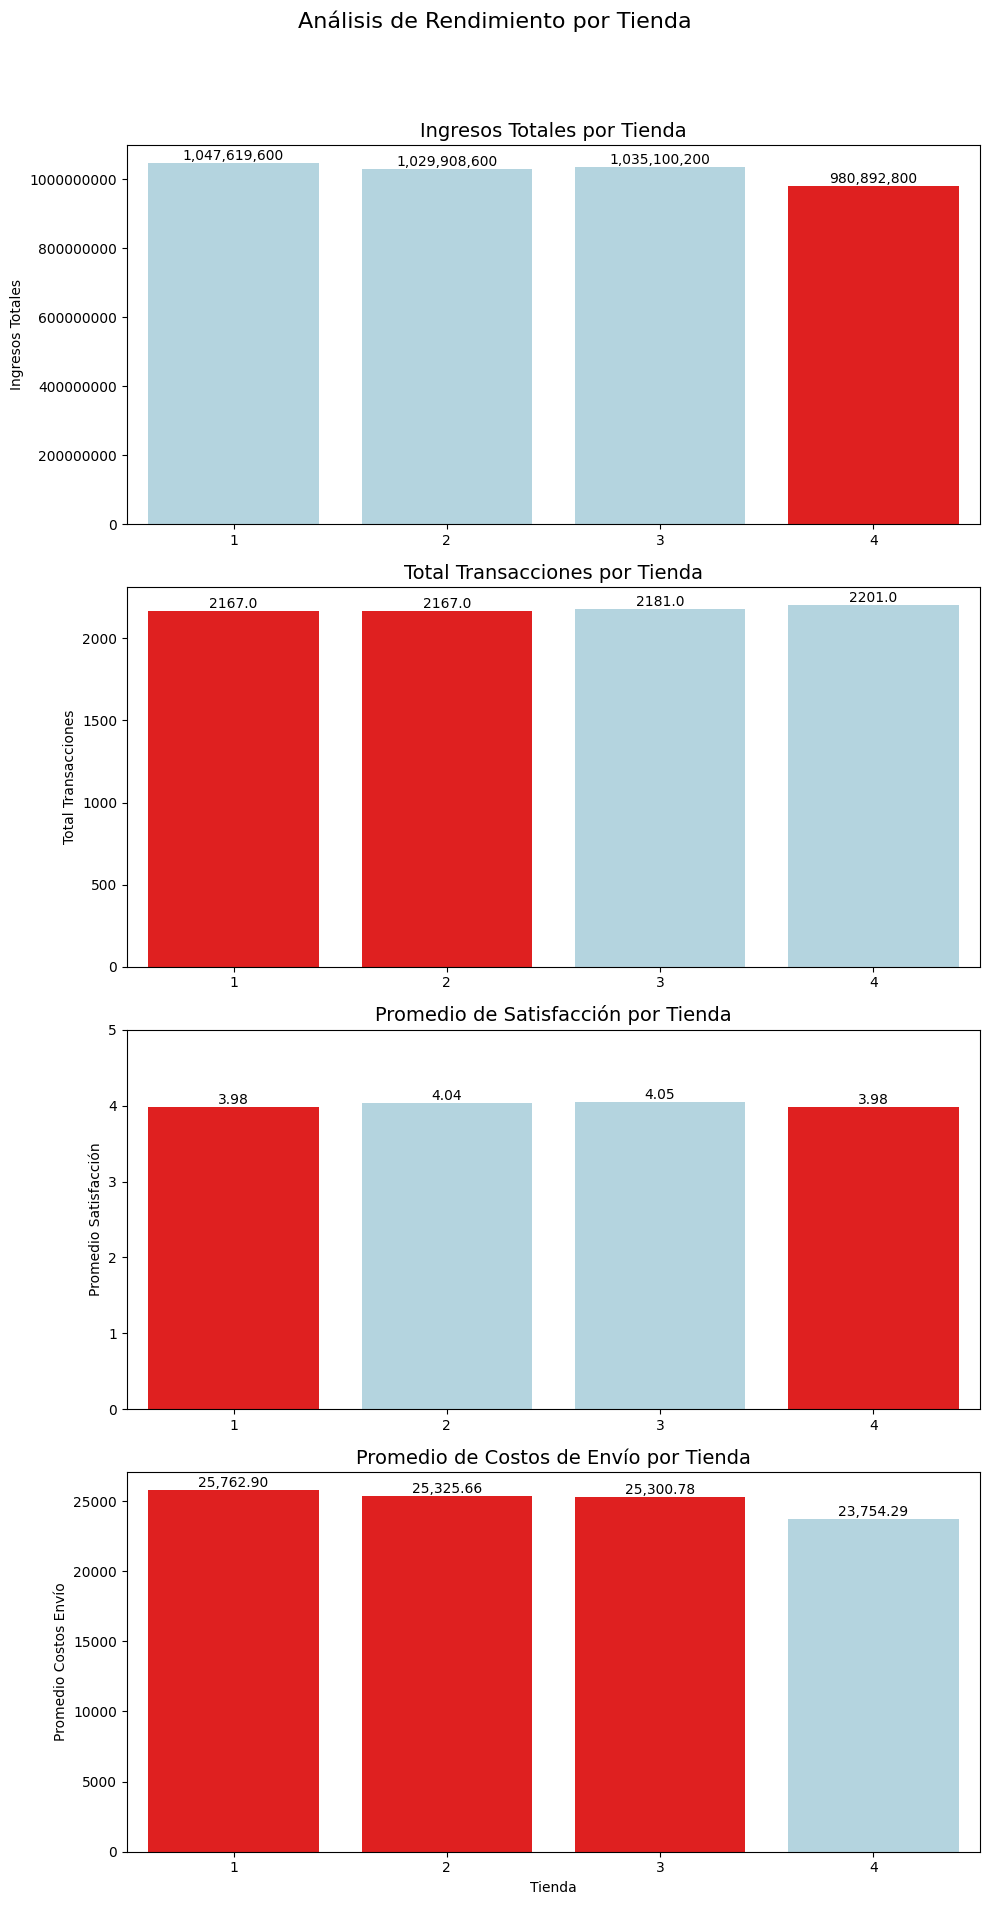

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate global averages from base_rendimiento_tienda
ingresoPromedioGlobalTienda = base_rendimiento_tienda['INGRESOS_TOTALES'].mean()
transaccionesPromedioGlobalTienda = base_rendimiento_tienda['TOTAL_TRANSACCIONES'].mean()
satisfaccionPromedioGlobalTienda = base_rendimiento_tienda['PROMEDIO_SATISFACCION'].mean()
costoEnvioPromedioGlobalTienda = base_rendimiento_tienda['PROMEDIO_COSTOS_ENVIO'].mean()

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 20))
fig.suptitle('Análisis de Rendimiento por Tienda', fontsize=16)

# Plot 1: Ingresos Totales
colorsIngresos = ['red' if val < ingresoPromedioGlobalTienda else 'lightblue' for val in base_rendimiento_tienda['INGRESOS_TOTALES']]
sns.barplot(x='TIENDA', y='INGRESOS_TOTALES', data=base_rendimiento_tienda, ax=axes[0], palette=colorsIngresos, hue='TIENDA', legend=False)
axes[0].set_title('Ingresos Totales por Tienda', fontsize=14)
axes[0].set_xlabel('')
axes[0].set_ylabel('Ingresos Totales')
axes[0].ticklabel_format(style='plain', axis='y') # Prevent scientific notation
for index, row in base_rendimiento_tienda.iterrows():
    axes[0].text(index, row['INGRESOS_TOTALES'], f'{row['INGRESOS_TOTALES']:,.0f}', color='black', ha="center", va='bottom')


# Plot 2: Total Transacciones
colorsTransacciones = ['red' if val < transaccionesPromedioGlobalTienda else 'lightblue' for val in base_rendimiento_tienda['TOTAL_TRANSACCIONES']]
sns.barplot(x='TIENDA', y='TOTAL_TRANSACCIONES', data=base_rendimiento_tienda, ax=axes[1], palette=colorsTransacciones, hue='TIENDA', legend=False)
axes[1].set_title('Total Transacciones por Tienda', fontsize=14)
axes[1].set_xlabel('')
axes[1].set_ylabel('Total Transacciones')
for index, row in base_rendimiento_tienda.iterrows():
    axes[1].text(index, row['TOTAL_TRANSACCIONES'], f'{row['TOTAL_TRANSACCIONES']}', color='black', ha="center", va='bottom')

# Plot 3: Promedio Satisfacción
colorsSatisfaccion = ['red' if val < satisfaccionPromedioGlobalTienda else 'lightblue' for val in base_rendimiento_tienda['PROMEDIO_SATISFACCION']]
sns.barplot(x='TIENDA', y='PROMEDIO_SATISFACCION', data=base_rendimiento_tienda, ax=axes[2], palette=colorsSatisfaccion, hue='TIENDA', legend=False)
axes[2].set_title('Promedio de Satisfacción por Tienda', fontsize=14)
axes[2].set_xlabel('') # Removed x-label as it will be at the bottom
axes[2].set_ylabel('Promedio Satisfacción')
axes[2].set_ylim(0, 5) # Assuming a scale of 0-5 for satisfaction
for index, row in base_rendimiento_tienda.iterrows():
    axes[2].text(index, row['PROMEDIO_SATISFACCION'], f'{row['PROMEDIO_SATISFACCION']:.2f}', color='black', ha="center", va='bottom')

# Plot 4: Promedio Costos de Envío
colorsCostosEnvio = ['red' if val > costoEnvioPromedioGlobalTienda else 'lightblue' for val in base_rendimiento_tienda['PROMEDIO_COSTOS_ENVIO']]
sns.barplot(x='TIENDA', y='PROMEDIO_COSTOS_ENVIO', data=base_rendimiento_tienda, ax=axes[3], palette=colorsCostosEnvio, hue='TIENDA', legend=False)
axes[3].set_title('Promedio de Costos de Envío por Tienda', fontsize=14)
axes[3].set_xlabel('Tienda')
axes[3].set_ylabel('Promedio Costos Envío')
axes[3].ticklabel_format(style='plain', axis='y')
for index, row in base_rendimiento_tienda.iterrows():
    axes[3].text(index, row['PROMEDIO_COSTOS_ENVIO'], f'{row['PROMEDIO_COSTOS_ENVIO']:,.2f}', color='black', ha="center", va='bottom')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap
plt.show()

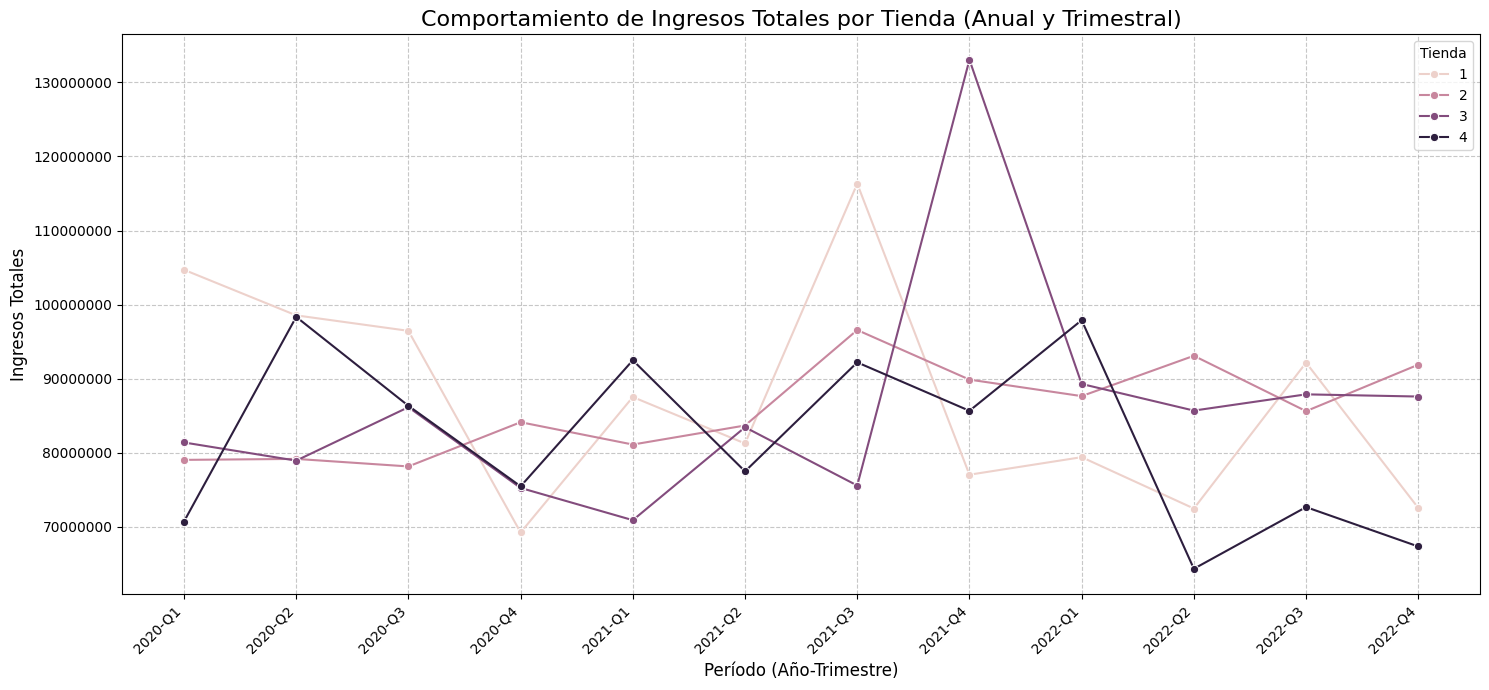

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 'Periodo' column for chronological order on the x-axis
totalVentasxTiendaTrimestral['Periodo'] = totalVentasxTiendaTrimestral['TrnAnio'].astype(str) + '-Q' + totalVentasxTiendaTrimestral['TrnTrimestre'].astype(str)

# Ensure periods are sorted for correct plotting order
totalVentasxTiendaTrimestral_sorted = totalVentasxTiendaTrimestral.sort_values(by=['TrnAnio', 'TrnTrimestre'])

plt.figure(figsize=(15, 7))
sns.lineplot(x='Periodo', y='TrnVenta', hue='Tienda', data=totalVentasxTiendaTrimestral_sorted, marker='o')

plt.title('Comportamiento de Ingresos Totales por Tienda (Anual y Trimestral)', fontsize=16)
plt.xlabel('Período (Año-Trimestre)', fontsize=12)
plt.ylabel('Ingresos Totales', fontsize=12)
plt.ticklabel_format(style='plain', axis='y') # Prevent scientific notation on y-axis
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 5. Resultados del Análisis y Acciones a Tomar